In [17]:
import glob
import json
import os

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats

In [18]:
import warnings
warnings.filterwarnings('ignore')

# Data loading

In [19]:
def load_reports(filename):
    """
    Generate dataframe from JSON report of queries from `bench-tools.nf` pipeline
    """
    df = pd.read_json(filename)
    df["benchmark"].fillna("x-0.1-0", inplace=True)
    df["percent-real"] = df["benchmark"].apply(lambda x: x.split('-')[1]).astype(float)
    df["num_usr"] = pd.to_numeric(df["usr_time"]) / 1e9
    df["num_sys"] = pd.to_numeric(df["sys_time"]) / 1e9
    df["total_time"] = df["num_usr"] + df["num_sys"]
    return df

def load_sizes(filenames):
    """
    Get size of benchmark datasets from the `generate-benchmarks.nf` pipeline
    """
    sizes = dict()
    for filename in filenames:
        with open(filename, "r") as file:
            d = json.load(file)
            sizes[d["organism"]] = d["size"]
    return sizes

In [20]:
benchmark_size_files = glob.glob("../data/**/*.benchmark_size.json")
result_files = glob.glob("../results/**/CBD.json")
indexed_kmers = glob.glob("../data/**/sorted.kmers.31.*.txt")

In [21]:
benchmark_sizes = load_sizes(benchmark_size_files)
indexed_kmer_number = dict()
for filename in indexed_kmers:
    s = os.path.getsize(filename)
    indexed_kmer_number[filename.split(".")[-2]] = int(s / 32)

indexed_kmer_number["meta_human"] = int(89799226304 / 32)

In [22]:
all_res = []
for filename in result_files:
    df = load_reports(filename)
    org = df["organism"].iloc[0]
    load_time = df[df["task"] == "CBD load"]["total_time"].mean()
    df["time-per-kmer"] = (df["total_time"] - load_time) / benchmark_sizes[org]
    all_res.append(df)

concated = pd.concat(all_res)

# Data processing

In [23]:
queries = concated[concated["task"].isin(["CBD contains", "CBD neighbours"])]
melted = pd.melt(queries, id_vars=["organism", "percent-real", "task"], value_vars=["time-per-kmer", "max_rss"])

# Data plotting

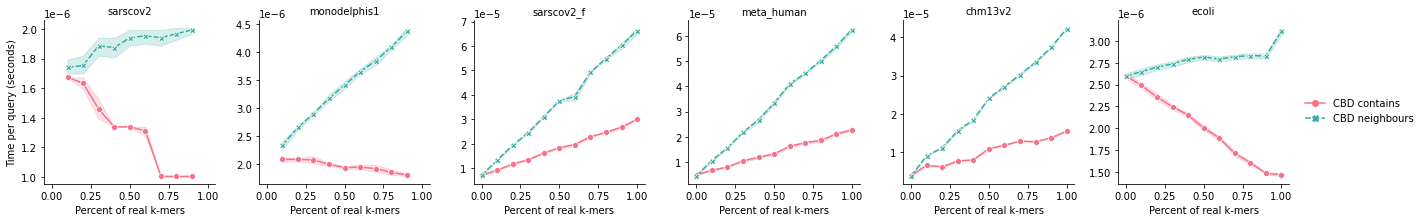

In [24]:
grid_time = (sns.FacetGrid(data=melted[melted["variable"] == "time-per-kmer"], col="organism", sharey=False)
     .map_dataframe(sns.lineplot, x="percent-real", y="value", hue="task", style="task", markers=True, palette="husl")
     .set_titles("{col_name}")
     .set_axis_labels("Percent of real k-mers", "Time per query (seconds)")
     .add_legend())
plt.show()

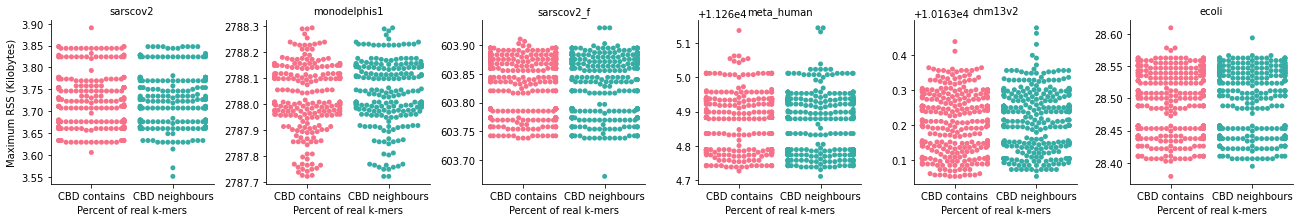

In [25]:
rounded_mem = melted[melted["variable"] == "max_rss"]
rounded_mem["value"] = rounded_mem["value"].apply(lambda x: x/1024)
grid_mem = (sns.FacetGrid(data=rounded_mem, col="organism", sharey=False)
     .map_dataframe(sns.swarmplot, x="task", y="value", palette="husl")
     .set_titles("{col_name}")
     .set_axis_labels("Percent of real k-mers", "Maximum RSS (Kilobytes)")
     .add_legend())
plt.show()

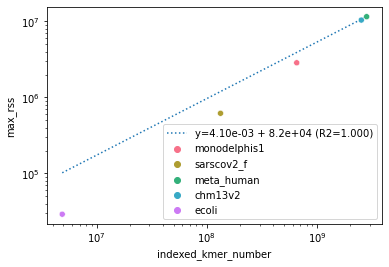

In [26]:
build = concated[(concated["task"] == "CBD build") & (concated["organism"] != "sarscov2")]
build["indexed_kmer_number"] = build["organism"].apply(indexed_kmer_number.get)
build["time-per-kmer"] = build["total_time"] / build["indexed_kmer_number"]

slope, intercept, r_sq, _, _ = stats.linregress(build["indexed_kmer_number"], build["max_rss"])

reg_xs= [build["indexed_kmer_number"].min(), build["indexed_kmer_number"].max()]
reg_ys= [x * slope + intercept for x in reg_xs]

sns.scatterplot(data=build, x="indexed_kmer_number", y="max_rss", palette="husl", hue="organism")
plt.plot(reg_xs, reg_ys, ls=":", zorder=0.5, label=f"y={slope:.2e} + {intercept:.1e} (R2={r_sq:.3f})")
plt.legend()
plt.xscale("log")
plt.yscale("log") 

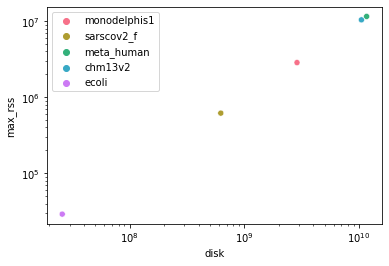

In [27]:
sns.scatterplot(data=build, x="disk", y="max_rss", palette="husl", hue="organism")
plt.legend()
plt.yscale("log")
plt.xscale("log")

In [28]:
build

,usr_time,sys_time,max_rss,avg_rss,disk,task,organism,benchmark,percent-real,num_usr,num_sys,total_time,time-per-kmer,indexed_kmer_number
0,1970-01-01 00:05:06.710,1970-01-01 00:00:34.470,2854992,0,2.873932e+09,CBD build,monodelphis1,x-0.1-0,0.1,306.71,34.47,341.18,5.233360e-07,651932951
0,1970-01-01 00:00:49.060,1970-01-01 00:00:07.490,618060,0,6.222764e+08,CBD build,sarscov2_f,x-0.1-0,0.1,49.06,7.49,56.55,4.257680e-07,132818800
0,1970-01-01 00:16:45.480,1970-01-01 00:02:11.470,11535176,0,1.161911e+10,CBD build,meta_human,x-0.1-0,0.1,1005.48,131.47,1136.95,4.051527e-07,2806225822
0,1970-01-01 00:15:11.910,1970-01-01 00:01:30.930,10407424,0,1.047184e+10,CBD build,chm13v2,x-0.1-0,0.1,911.91,90.93,1002.84,3.991578e-07,2512390070
0,1970-01-01 00:00:01.780,1970-01-01 00:00:00.130,29052,0,2.583392e+07,CBD build,ecoli,x-0.1-0,0.1,1.78,0.13,1.91,3.916021e-07,4877400
